In [50]:
# Cell 1: Imports and setup
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

%matplotlib inline

main_dir = os.getcwd() + '\\'
data_name = main_dir + 'match_vectors_no_label.csv'

shuffled = True
shuffled_data_name = main_dir + 'match_vectors_no_label_shuffled.csv'
FEATURE_LABEL = ['h_roster_rating', 'h_gk_rating', 'h_def_rating', 'h_mid_rating',
                 'h_off_rating', 'a_roster_rating', 'a_gk_rating', 'a_def_rating',
                 'a_mid_rating', 'a_off_rating', 'label']

In [51]:
# Cell 2: Core functions
def add_x0(x):
    return_x = np.zeros((x.shape[0], x.shape[1] + 1))
    return_x[:, 0] = 1
    return_x[:, 1:] = x
    return return_x

def define_xy(data, L_i, ratio=0.8, draw_is_loss=True):
    x = add_x0(data[:, L_i])
    y = data[:, -1].copy()
    
    if draw_is_loss:
        y[y < 1] = 0
    else:
        y[y < 0] = 0
        y[y >= 0] = 1
    
    i_split = int(len(y) * ratio)
    return x[:i_split, :], y[:i_split], x[i_split:, :], y[i_split:]

def h_logreg(x_i, theta):
    return 1.0 / (1 + np.exp(-x_i.dot(theta)))

def grad_l(x, y, theta, lmda=1e1):
    h = h_logreg(x, theta)
    grad = (y - h).dot(x)
    return grad - lmda * theta

def logreg(x, y, eps=1e-15, alpha=1e-5, lmda=1e1):
    d = x.shape[1]
    theta = np.zeros(d)
    itr = 0
    
    while True:
        itr += 1
        prev_theta = theta.copy()
        theta = theta + alpha * grad_l(x, y, theta, lmda)
        eps_i = np.linalg.norm(prev_theta - theta)
        if itr % 10000 == 0:
            print(f"Iteration {itr}, Δtheta={eps_i}")
        if eps_i < eps:
            print(f"Converged at iteration {itr}, Δtheta={eps_i}")
            break
    return theta

In [52]:
# Cell 3: Visualization functions (display in notebook)
def plot_prediction(x_test, y_test, theta, title=''):
    h = np.array([h_logreg(x_test[i, :], theta) for i in range(len(y_test))])
    y_predict = np.array([1 if h_i >= 0.5 else 0 for h_i in h])
    
    accuracy = np.sum(y_test == y_predict) / len(y_test)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(h, 'g-', alpha=0.7)
    ax1.set_ylabel('Predicted Probability h(x)')
    ax1.set_title(f'{title} - Predictions (Accuracy: {accuracy:.2%})')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(y_test, 'ro', markersize=4, label='Actual')
    ax2.plot(y_predict, 'bo', markersize=2, label='Predicted')
    ax2.legend()
    ax2.set_ylabel('Label (0=Loss, 1=Win)')
    ax2.set_xlabel('Test Set Data Points')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title=''):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Loss', 'Predicted Win'],
                yticklabels=['Actual Loss', 'Actual Win'])
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_decision(x, y, theta, L_i, i1, i2, title=''):
    x1, x2 = x[:, i1+1], x[:, i2+1]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(x1[y == 0], x2[y == 0], c='red', marker='+', s=50, label='Loss', alpha=0.7)
    plt.scatter(x1[y == 1], x2[y == 1], c='blue', marker='+', s=50, label='Win', alpha=0.7)
    
    x1_min, x1_max = np.min(x1), np.max(x1)
    x_decision = np.linspace(x1_min, x1_max, 100)
    
    th0, th1, th2 = theta[0], theta[i1+1], theta[i2+1]
    slope = -th1 / th2
    intercept = -th0 / th2
    plt.plot(x_decision, slope * x_decision + intercept, 'k-', linewidth=2, label='Decision Boundary')
    
    plt.xlabel(FEATURE_LABEL[L_i[i1]])
    plt.ylabel(FEATURE_LABEL[L_i[i2]])
    plt.legend()
    plt.title(f'{title} - Decision Boundary (Features {i1} vs {i2})')
    plt.grid(True, alpha=0.3)
    plt.show()

In [53]:
# Cell 4: Metrics and main logic functions
def print_classification_report(y_true, y_pred, title=''):
    report = classification_report(y_true, y_pred, 
                                  target_names=['Loss', 'Win'],
                                  output_dict=False)
    print(f"\n{title} - Classification Report:")
    print(report)
    
    report_dict = classification_report(y_true, y_pred, 
                                       target_names=['Loss', 'Win'],
                                       output_dict=True)
    return report_dict

def calculate_additional_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'specificity': specificity,
        'confusion_matrix': cm
    }

def do_logreg(data, L_i, trained=False, ratio=0.8, show_plots=True,
              eps=1e-15, alpha=1e-5, lmda=1e1, max_decision_plots=2):
    feature_title = "features_" + "_".join([str(i) for i in L_i])
    
    print(f"\n{'='*60}")
    print(f"Training: {feature_title}")
    print(f'Features: {[FEATURE_LABEL[i] for i in L_i]}')
    print(f"{'='*60}")
    
    x_train, y_train, x_test, y_test = define_xy(data, L_i, ratio)
    
    theta_file = main_dir + feature_title + "_theta.csv"
    
    if trained and os.path.exists(theta_file):
        print(f"Loading theta from {theta_file}")
        theta = np.genfromtxt(theta_file, delimiter=',')
    else:
        print(f"Training logistic regression...")
        theta = logreg(x_train, y_train, eps=eps, alpha=alpha, lmda=lmda)
        np.savetxt(theta_file, theta, delimiter=',')
        print(f"Training completed! Theta saved to {theta_file}")
    
    h_test = np.array([h_logreg(x_test[i, :], theta) for i in range(len(y_test))])
    y_pred = np.array([1 if h_i >= 0.5 else 0 for h_i in h_test])
    
    # Print metrics
    report_dict = print_classification_report(y_test, y_pred, feature_title)
    
    metrics = calculate_additional_metrics(y_test, y_pred)
    print(f"\n{feature_title} - Additional Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    
    # Display plots in notebook
    if show_plots:
        print(f"\nGenerating visualizations...")
        plot_prediction(x_test, y_test, theta, feature_title)
        plot_confusion_matrix(y_test, y_pred, feature_title)
        
        # Only plot limited decision boundaries
        if len(L_i) >= 2:
            plot_count = 0
            # Plot only the most important feature pairs
            important_pairs = [(0,5), (0,1)]  # Home vs Away ratings
            for i, j in important_pairs:
                if i in L_i and j in L_i and plot_count < max_decision_plots:
                    i_idx = L_i.index(i)
                    j_idx = L_i.index(j)
                    plot_decision(x_test, y_test, theta, L_i, i_idx, j_idx, feature_title)
                    plot_count += 1
    
    return theta, metrics

In [54]:
# Cell 5: Data loading and preprocessing
print("Loading data...")
if not shuffled:
    print("Shuffling data...")
    data = np.genfromtxt(data_name, delimiter=',')
    np.savetxt(shuffled_data_name, shuffle(data), delimiter=',')
    print(f"Saved shuffled data to {shuffled_data_name}")

data = np.genfromtxt(shuffled_data_name, delimiter=',')
print(f"Loaded data with shape: {data.shape}")

print("Removing draws...")
original_size = len(data)
data = np.array([d for d in data if d[-1] != 0])
print(f"Removed {original_size - len(data)} draws. Remaining data: {len(data)}")

Loading data...
Loaded data with shape: (3791, 11)
Removing draws...
Removed 940 draws. Remaining data: 2851


Starting logistic regression analysis...

Training: features_0_1_2_3_4_5_6_7_8_9
Features: ['h_roster_rating', 'h_gk_rating', 'h_def_rating', 'h_mid_rating', 'h_off_rating', 'a_roster_rating', 'a_gk_rating', 'a_def_rating', 'a_mid_rating', 'a_off_rating']
Training logistic regression...
Iteration 10000, Δtheta=2.67662065588727e-05
Iteration 20000, Δtheta=4.0708274191383e-06
Iteration 30000, Δtheta=8.310851500545928e-07
Iteration 40000, Δtheta=2.1940341766092583e-07
Iteration 50000, Δtheta=6.847364140911034e-08
Iteration 60000, Δtheta=2.3004630475250438e-08
Iteration 70000, Δtheta=7.932816201703929e-09
Iteration 80000, Δtheta=2.759035516114855e-09
Iteration 90000, Δtheta=9.623160968818282e-10
Iteration 100000, Δtheta=3.359894153616312e-10
Iteration 110000, Δtheta=1.1736539104659075e-10
Iteration 120000, Δtheta=4.101004306530549e-11
Iteration 130000, Δtheta=1.4333894067326735e-11
Iteration 140000, Δtheta=5.011309518386388e-12
Iteration 150000, Δtheta=1.7526425226704873e-12
Iteration 1600

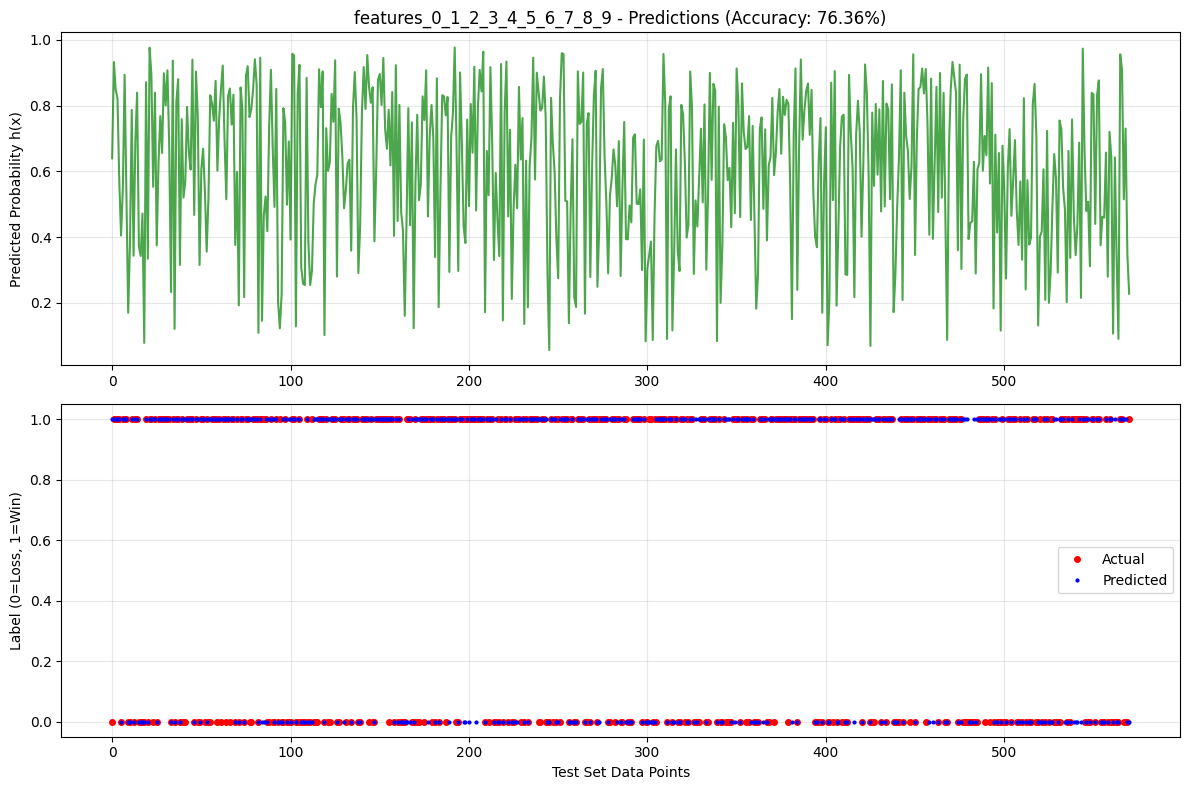

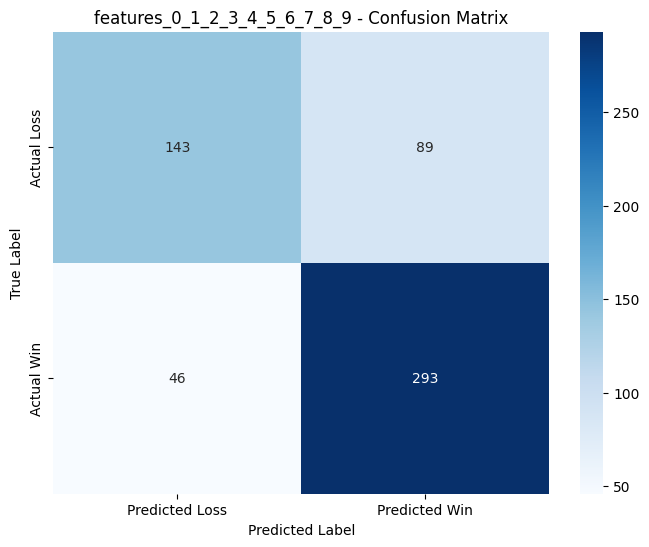

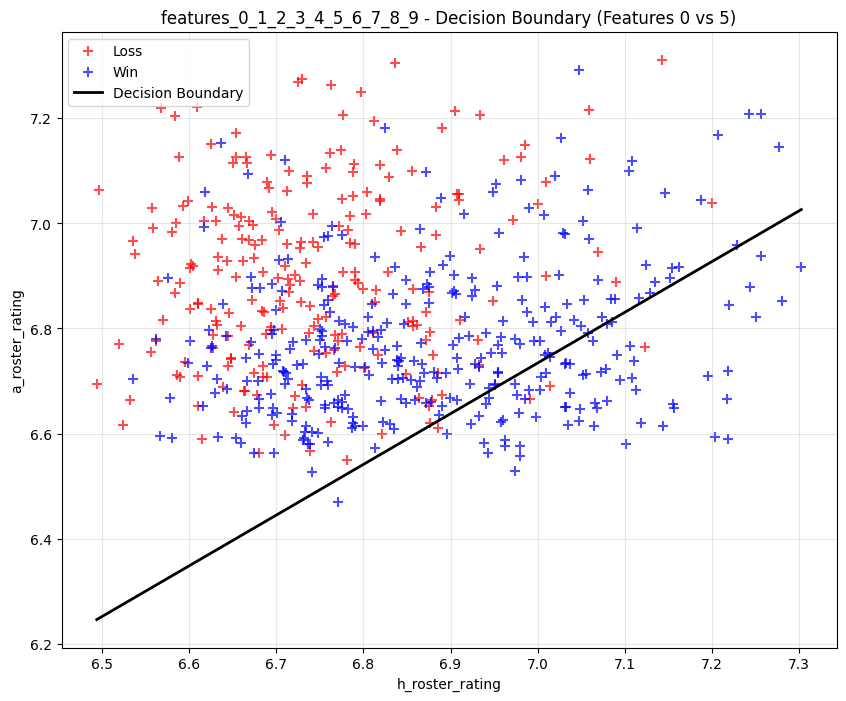

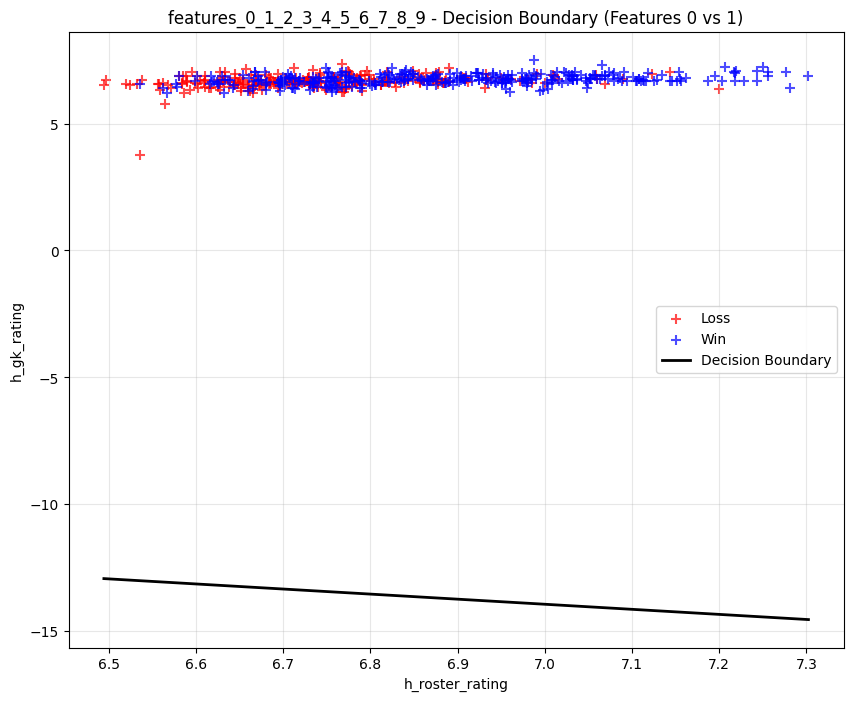

In [55]:
# Cell 6: Run logistic regression with all features
print("Starting logistic regression analysis...")
theta_all, metrics_all = do_logreg(data, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], trained=False, show_plots=True)


Training: features_0_5
Features: ['h_roster_rating', 'a_roster_rating']
Training logistic regression...
Iteration 10000, Δtheta=9.906947941778368e-05
Iteration 20000, Δtheta=1.1662540994103354e-05
Iteration 30000, Δtheta=1.4113961624590194e-06
Iteration 40000, Δtheta=1.7984651339389935e-07
Iteration 50000, Δtheta=3.0282482847417554e-08
Iteration 60000, Δtheta=8.490186750011682e-09
Iteration 70000, Δtheta=2.96217323640961e-09
Iteration 80000, Δtheta=1.0694468695746536e-09
Iteration 90000, Δtheta=3.876429324982039e-10
Iteration 100000, Δtheta=1.4057116592570897e-10
Iteration 110000, Δtheta=5.0977904090813096e-11
Iteration 120000, Δtheta=1.848714544147686e-11
Iteration 130000, Δtheta=6.7043592157170515e-12
Iteration 140000, Δtheta=2.431358680509648e-12
Iteration 150000, Δtheta=8.817233115234158e-13
Iteration 160000, Δtheta=3.19771585326274e-13
Iteration 170000, Δtheta=1.1594699336345973e-13
Iteration 180000, Δtheta=4.2052874723443714e-14
Iteration 190000, Δtheta=1.525442411892992e-14
Ite

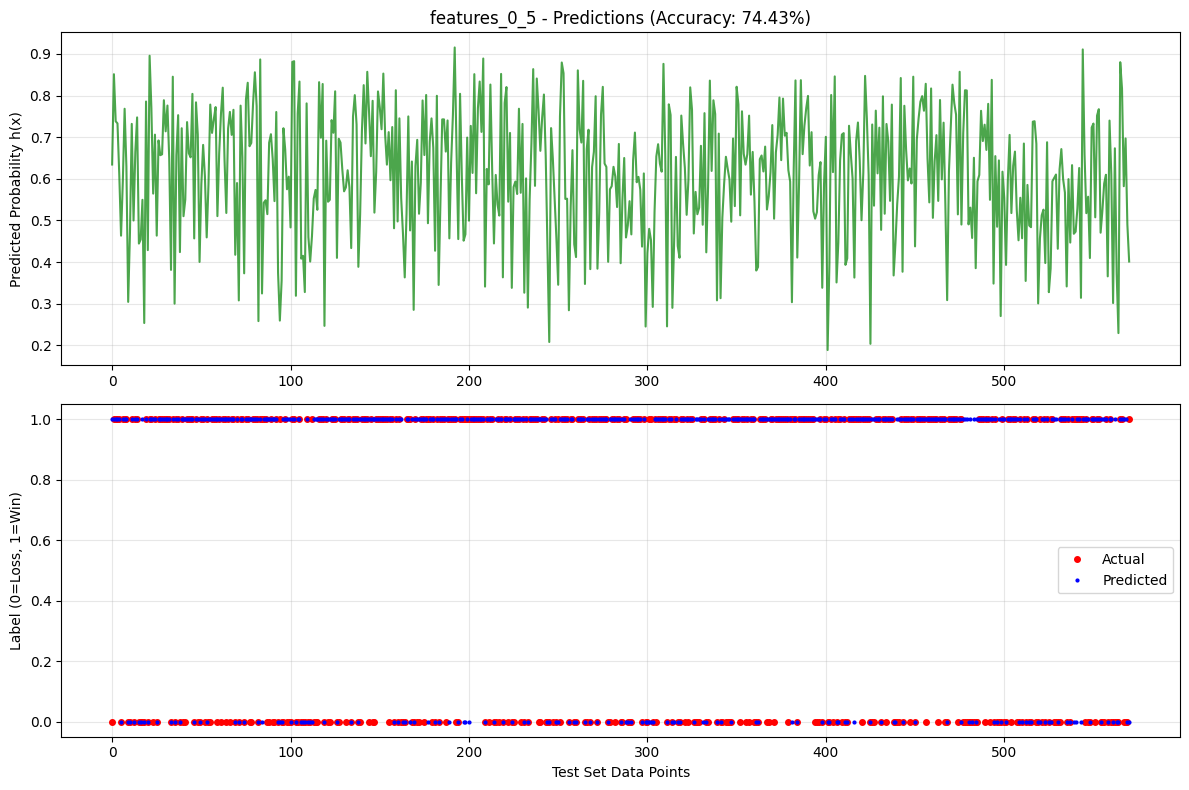

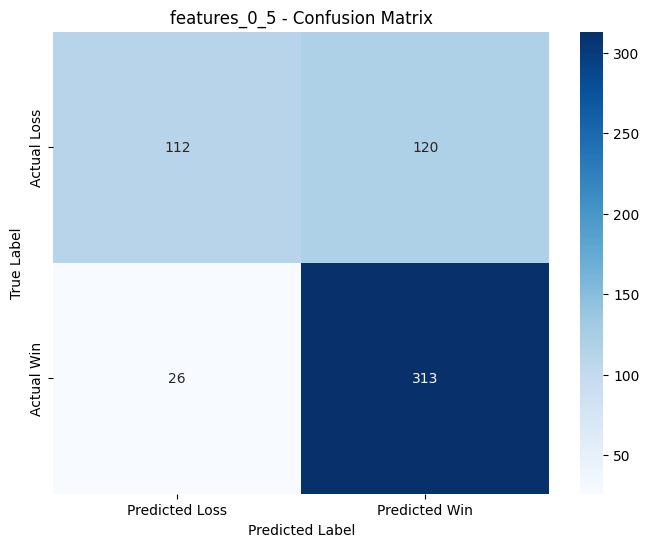

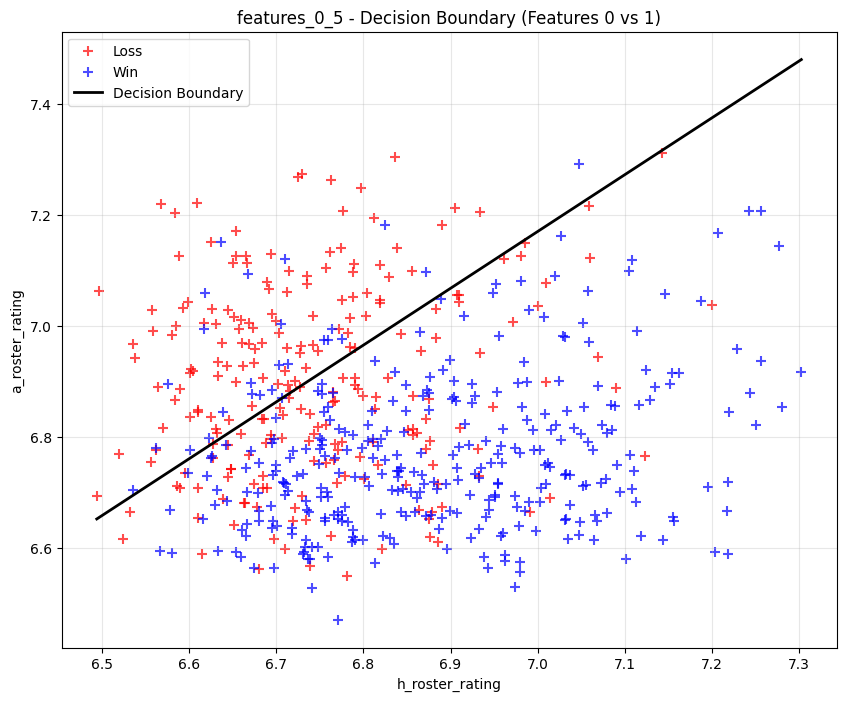

In [56]:
# Cell 7: Run logistic regression with selected features
theta_05, metrics_05 = do_logreg(data, [0, 5], trained=False, show_plots=True)

In [57]:
# Cell 8: Final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"All Features (0-9) Accuracy: {metrics_all['accuracy']:.4f}")
print(f"Features [0,5] Accuracy: {metrics_05['accuracy']:.4f}")

if metrics_all['accuracy'] > metrics_05['accuracy']:
    print("\n✓ Using all features provides better performance")
else:
    print("\n✓ Using selected features [0,5] provides comparable/better performance")

print(f"\nBest model accuracy: {max(metrics_all['accuracy'], metrics_05['accuracy']):.2%}")


FINAL SUMMARY
All Features (0-9) Accuracy: 0.7636
Features [0,5] Accuracy: 0.7443

✓ Using all features provides better performance

Best model accuracy: 76.36%
